In [1]:
import pandas as pd



In [2]:
df = pd.read_csv("../data/dataproject2025_preprocessed.csv")
df.head()

,num__issue_d,num__loan duration,num__annual_inc,num__avg_cur_bal,num__bc_open_to_buy,num__bc_util,num__delinq_2yrs,num__dti,num__fico_range_high,num__funded_amnt,...,cat__sub_grade_F3,cat__sub_grade_F4,cat__sub_grade_F5,cat__sub_grade_G1,cat__sub_grade_G2,cat__sub_grade_G3,cat__sub_grade_G4,cat__sub_grade_G5,Predicted probabilities,target
0,-1.687635,-0.637761,-0.740512,-0.745082,0.749479,-1.586997,-0.370384,-1.880644,2.106130,-1.180039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053051,0
1,-1.687635,-0.637761,-0.470965,-0.250508,0.416937,-0.242629,-0.370384,0.530276,1.258044,1.180387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084507,0
2,-1.687635,-0.637761,4.254853,2.390279,0.248935,0.226833,-0.370384,0.019227,1.766896,1.281169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037206,0
3,-1.687635,-0.637761,0.841762,1.367198,-0.426078,1.147974,-0.370384,-0.633779,0.749193,-0.416216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061371,0
4,-1.687635,1.567986,-0.155910,0.630499,-0.342077,0.497129,0.729341,0.561034,-0.946979,1.238734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.345896,1


In [3]:
X = df.drop(columns = ["target", "Predicted probabilities"])
y = df["target"]

# To be deleted:

In [6]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    verbose=0,        # no training logs
    random_seed=42,   # reproducibility
    eval_metric="Logloss"
)

model.fit(X, y)


In [8]:
from sklearn.inspection import permutation_importance
# Identify column types
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numeric_cols)
print(categorical_cols)
# Use a scoring metric (e.g., R^2, neg_mean_squared_error)
perm_importance = permutation_importance(
    model, X, y, n_repeats=5, random_state=42, scoring='r2'
)

# Get importance values
feature_names = numeric_cols + categorical_cols  # make sure to match preprocessed columns if needed
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importance_df)


['num__issue_d', 'num__loan duration', 'num__annual_inc', 'num__avg_cur_bal', 'num__bc_open_to_buy', 'num__bc_util', 'num__delinq_2yrs', 'num__dti', 'num__fico_range_high', 'num__funded_amnt', 'num__inq_last_6mths', 'num__int_rate', 'num__mo_sin_old_rev_tl_op', 'num__mo_sin_rcnt_rev_tl_op', 'num__mo_sin_rcnt_tl', 'num__mort_acc', 'num__mths_since_recent_bc', 'num__num_actv_bc_tl', 'num__num_bc_tl', 'num__num_il_tl', 'num__num_rev_accts', 'num__open_acc', 'num__pub_rec', 'num__pub_rec_bankruptcies', 'num__revol_bal', 'num__revol_util', 'num__tax_liens', 'num__zip_code', 'num__Pct_afro_american', 'cat__emp_length_1 year', 'cat__emp_length_10+ years', 'cat__emp_length_2 years', 'cat__emp_length_3 years', 'cat__emp_length_4 years', 'cat__emp_length_5 years', 'cat__emp_length_6 years', 'cat__emp_length_7 years', 'cat__emp_length_8 years', 'cat__emp_length_9 years', 'cat__emp_length_< 1 year', 'cat__emp_title_account executive', 'cat__emp_title_account manager', 'cat__emp_title_accountant', 

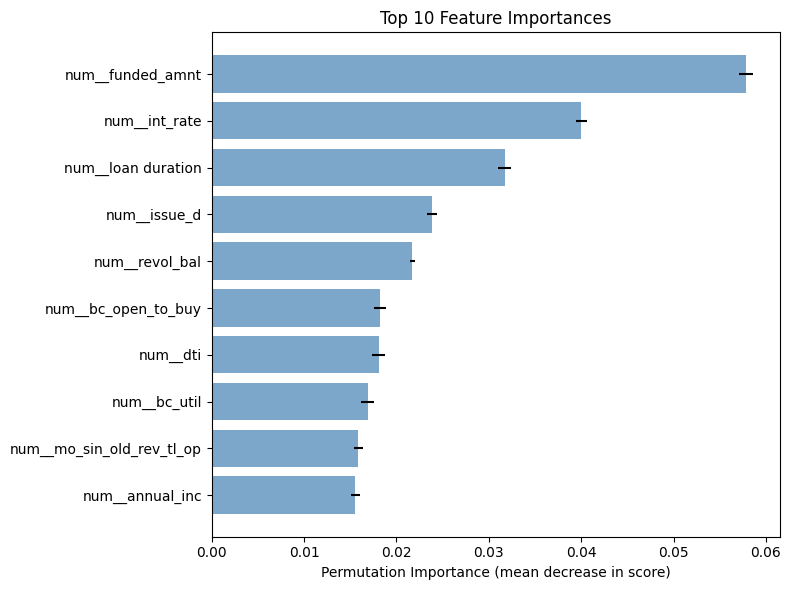

In [14]:
import matplotlib.pyplot as plt

top10 = importance_df.head(10)

plt.figure(figsize=(8, 6))
plt.barh(top10['feature'], top10['importance_mean'],
         xerr=top10['importance_std'], alpha=0.7, color='steelblue')
plt.gca().invert_yaxis()  # highest importance at top
plt.xlabel("Permutation Importance (mean decrease in score)")
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


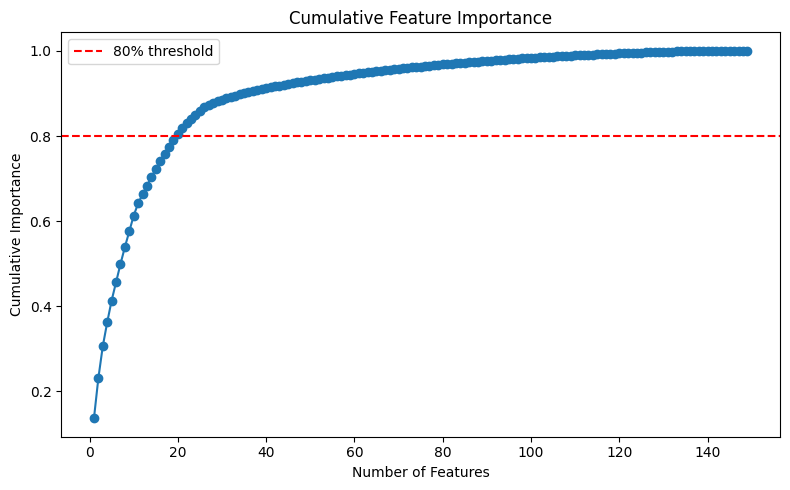

In [17]:
importance_df['cumulative'] = importance_df['importance_mean'].cumsum() / importance_df['importance_mean'].sum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(importance_df)+1), importance_df['cumulative'], marker='o')
plt.axhline(0.8, color="red", linestyle="--", label="80% threshold")
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.title("Cumulative Feature Importance")
plt.legend()
plt.tight_layout()
plt.show()



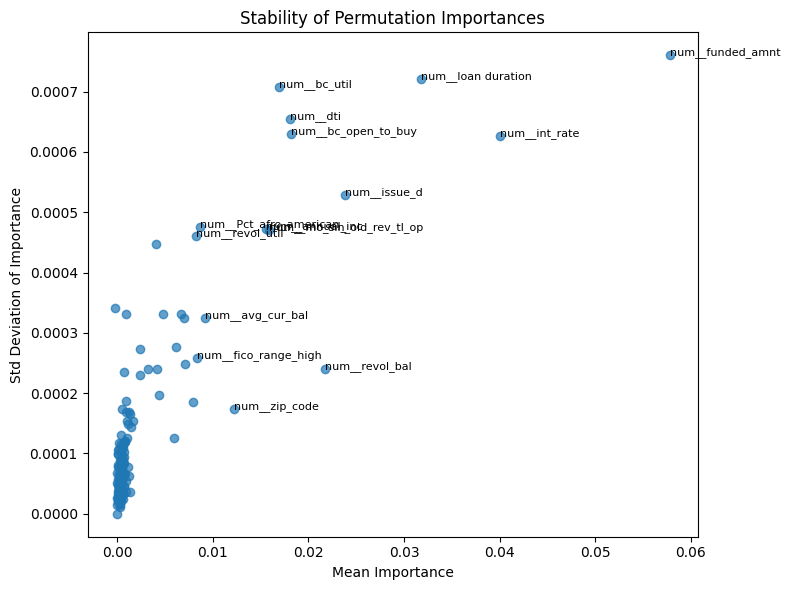

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(importance_df['importance_mean'], importance_df['importance_std'], alpha=0.7)

for i, row in importance_df.head(15).iterrows():  # label top 15 only
    plt.text(row['importance_mean'], row['importance_std'], row['feature'], fontsize=8)

plt.xlabel("Mean Importance")
plt.ylabel("Std Deviation of Importance")
plt.title("Stability of Permutation Importances")
plt.tight_layout()
plt.show()
